**IDL PROJECT 2020 - TEAM 8**
=====================================

Laia Prat Ortonobas

Albert Pérez Lozano

Anna Fernández-Rajal Sabala

Álvaro Guerin Almazor

### **Introduction:**
Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. The term "dropout" refers to dropping out units in a neural network. More technically,during the training phase the system ignores some units. 
At each training stage, individual nodes are either dropped out with probability p  or kept with probability 1-p. 

In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

> We will compare different probabilities adding a dropout layer just before the fully-connected layer. 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

> In the training phase for each iteration the system ignores a probability of layers.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch, p):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

> In the validation phase the system does not use the dropout layer because it is necessary to have the whole capability. In addition, if the dropout is used during this phase we will not get the best performance the network could be able to provide.

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),accuracy))
    
    return validation_loss, accuracy

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

> We appreciate how the algorism works with the different probabilities plotting a graph for each one.

Probability is: 0
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293073
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.695266
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.328718
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.386360
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.263161
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.137603

Validation set: Average loss: 0.1436, Accuracy: 9591/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.161273
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.127771
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.093980
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.200458
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.052256
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.218700

Validation set: Average loss: 0.0858, Accuracy: 9743/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047423
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.059487
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.027242
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.215726
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.104403
Train Epoch: 

<Figure size 432x288 with 0 Axes>

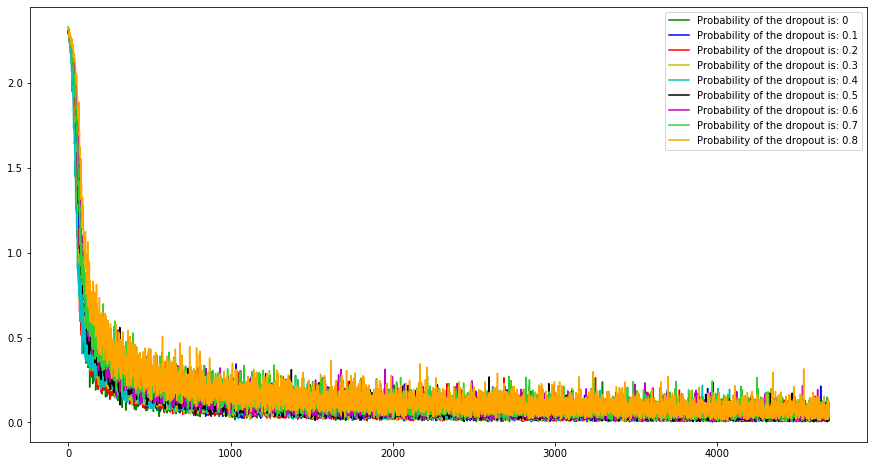

<Figure size 432x288 with 0 Axes>

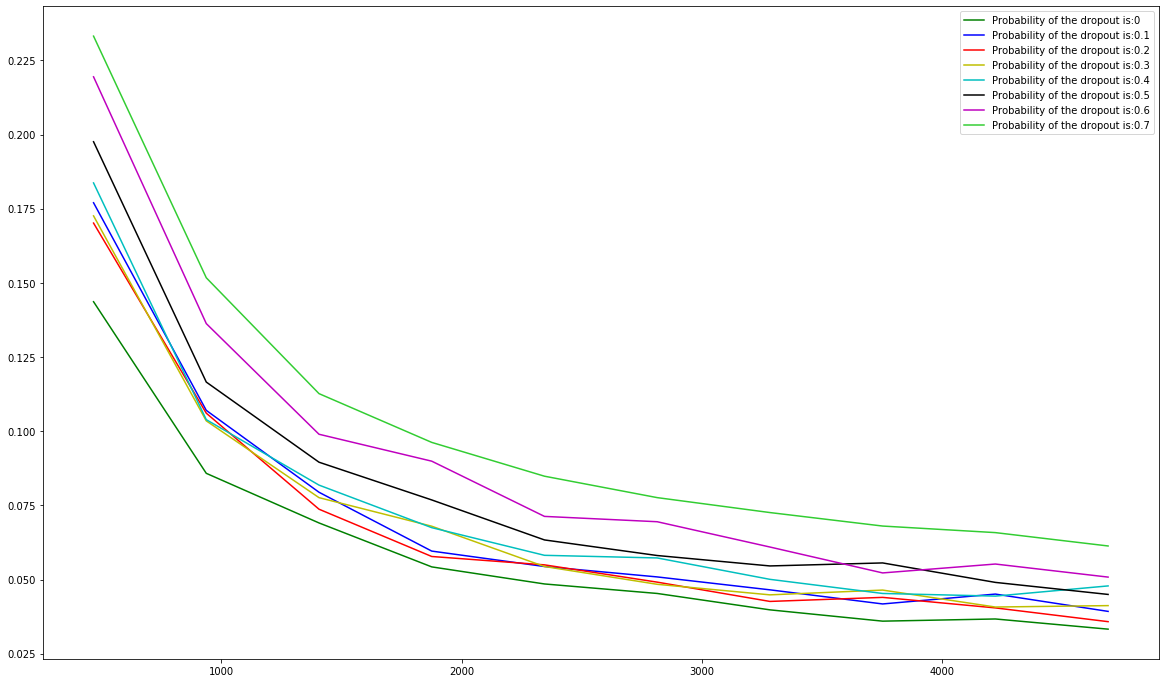

<Figure size 432x288 with 0 Axes>

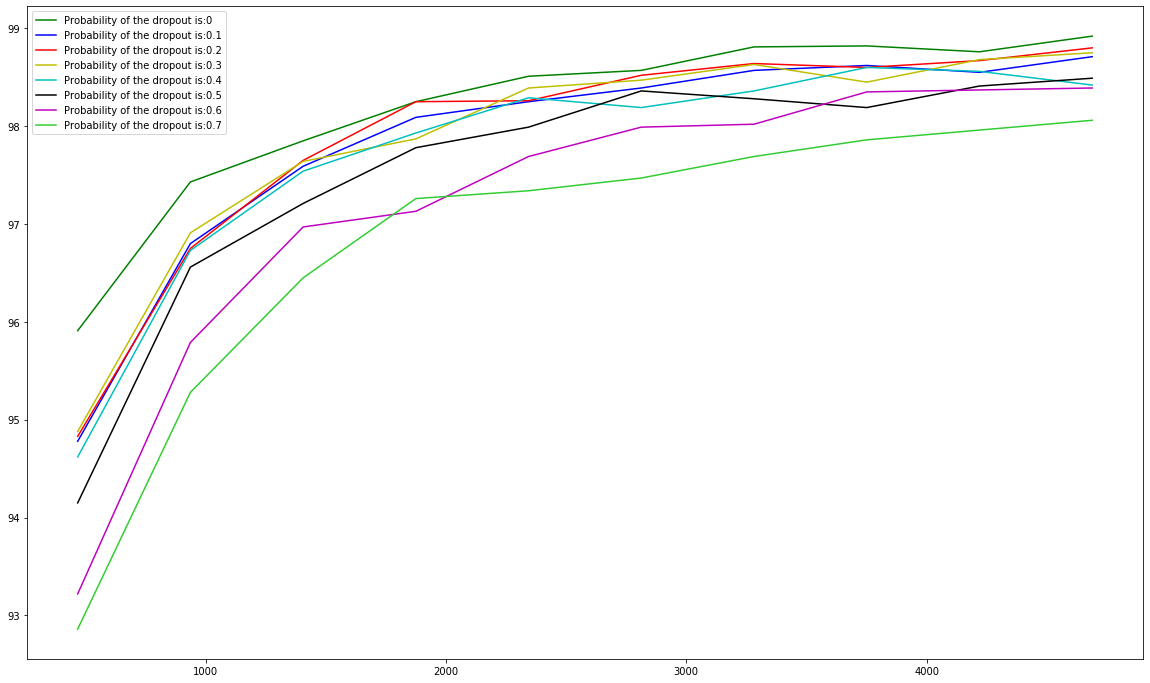

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
prob_vector = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
train_losses_total = []
valid_losses_total = []
valid_x_total = []
colors=['g-', 'b-', 'r-', 'y-', 'c-', 'k-', 'm-', 'limegreen', 'orange']
accuracy_vector_total = []
plt.gcf().clear()
plt.figure(figsize=(15,8))
for p in prob_vector:
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    print("Probability is: "+str(p))
    train_losses = []
    valid_losses = []
    valid_x = []
    accuracy_vector = []
    num_epochs = 10
    for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, p)
      train_losses.extend(epoch_losses)
      valid_loss, accuracy = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)
      accuracy_vector.append(accuracy)
    valid_x_total.append(valid_x)
    train_losses_total.append(train_losses)
    valid_losses_total.append(valid_losses)
    accuracy_vector_total.append(accuracy_vector)

    plt.plot(train_losses, colors[prob_vector.index(p)], label= 'Probability of the dropout is: ' +str(p))
    plt.legend(loc='upper right')

plt.show()
plt.gcf().clear()
plt.figure(figsize=(20,12))
for i in range(len(prob_vector)-1): 
  plt.plot(valid_x_total[i], valid_losses_total[i], colors[i], label = 'Probability of the dropout is:' + str(prob_vector[i]))
  plt.legend(loc='upper right')
plt.show()

plt.gcf().clear()
plt.figure(figsize=(20,12))
for i in range(len(prob_vector)-1): 
  plt.plot(valid_x_total[i], accuracy_vector_total[i], colors[i], label = 'Probability of the dropout is:' + str(prob_vector[i]))
  plt.legend(loc='upper left')
plt.show()

### **Conclusions:**

First things first, we have accessed to only inserting a single dropout layer and in order to improve the actual results we decided to insert more than one dropout layer. As a surprise, we saw that the obtained results on the second were much worser.

From the performances with the different probabilities, we are able to remark that the dropout's threshold is very important. As, till a certain point increasing the dropout probability the accuracy increases. Furthermore, at the point this threshold is surpassed the system's accuracy will start to decrease. 